In [1]:
import torch
from earth2studio.models.auto import Package
from SFNO_update import SFNO

# We only need one checkpoint to inspect the architecture
src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
checkpoint_name = 'ckpt_mp0_epoch1.tar'

print("Loading package...")
model_package = Package(src_dir, cache=False)

print("Loading model wrapper...")
model_wrapper = SFNO.load_model(model_package, checkpoint_name=checkpoint_name, EMA=False)

print("\n" + "="*50)
print("TOP LEVEL WRAPPER TYPE:")
print(type(model_wrapper))
print("="*50)

print("\nTOP LEVEL ATTRIBUTES:")
print([a for a in dir(model_wrapper) if not a.startswith('_')])

# Traverse down common wrapper attribute names ('model', 'network', 'module')
current_level = model_wrapper
path = "model_wrapper"

# dig down up to 5 levels to find the PyTorch nn.Module
for i in range(5):
    if isinstance(current_level, torch.nn.Module):
        print(f"\nFound PyTorch nn.Module at: {path}")
        print("-" * 50)
        print(current_level)
        break
    elif hasattr(current_level, 'model'):
        print(f"Level {i}: {path} is not an nn.Module, but it has a '.model' attribute. Digging deeper...")
        current_level = current_level.model
        path += ".model"
    elif hasattr(current_level, 'module'):
        print(f"Level {i}: {path} has a '.module' attribute. Digging deeper...")
        current_level = current_level.module
        path += ".module"
    elif hasattr(current_level, 'network'):
        print(f"Level {i}: {path} has a '.network' attribute. Digging deeper...")
        current_level = current_level.network
        path += ".network"
    else:
        print(f"\nHit a dead end at {path}. It is not an nn.Module and has no obvious child network attributes.")
        break
        

/projectnb/eb-general/wade/.conda/envs/earth2studio/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/projectnb/eb-general/wade/.conda/envs/earth2studio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading package...
Loading model wrapper...

TOP LEVEL WRAPPER TYPE:
<class 'SFNO_update.SFNO'>

TOP LEVEL ATTRIBUTES:
['T_destination', 'add_module', 'apply', 'bfloat16', 'buffers', 'call_super_init', 'children', 'compile', 'cpu', 'create_iterator', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'from_pretrained', 'front_hook', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_submodule', 'half', 'input_coords', 'ipu', 'load_default_package', 'load_model', 'load_state_dict', 'model', 'modules', 'mtia', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'output_coords', 'parameters', 'rear_hook', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_load_state_dict_pre_hook', 'register_module', 'register_parameter', 'register_state_dict_post_hook', 'register_state_dict_pre_ho

In [4]:
def find_blocks_path(obj, current_path="model_wrapper", depth=0):
    if depth > 10:  # Prevent infinite loops
        return
        
    # Check if this specific object has the 'blocks' attribute
    if hasattr(obj, 'blocks'):
        print(f"\n✅ FOUND IT! The exact path is: {current_path}")
        print(f"Type of this object: {type(obj)}")
        return

    # If it's a PyTorch module, iterate through its children
    if isinstance(obj, torch.nn.Module):
        for name, child in obj.named_children():
            find_blocks_path(child, f"{current_path}.{name}", depth + 1)
            
    # Also check common wrapper attributes just in case they are hidden
    for attr_name in ['model', 'module', 'network']:
        if hasattr(obj, attr_name) and not isinstance(obj, torch.nn.Module):
            child = getattr(obj, attr_name)
            find_blocks_path(child, f"{current_path}.{attr_name}", depth + 1)

print("Searching for the 'blocks' attribute...")
find_blocks_path(model_wrapper)

Searching for the 'blocks' attribute...

✅ FOUND IT! The exact path is: model_wrapper.model.model.model
Type of this object: <class 'makani.models.networks.sfnonet.SphericalFourierNeuralOperatorNet'>


In [ ]:
import torch
from earth2studio.models.auto import Package
from SFNO_update import SFNO

# Load the problematic epoch 30
src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
checkpoint_name = 'ckpt_mp0_epoch30.tar'

model_package = Package(src_dir, cache=False)
model_wrapper = SFNO.load_model(model_package, checkpoint_name=checkpoint_name, EMA=False)

print("--- SEARCHING FOR TARGET LAYERS ---")
# Iterate through EVERY module, no matter how deeply nested
for name, module in model_wrapper.named_modules():
    # Filter out the noise and only look for blocks, encoder, or decoder
    if any(keyword in name for keyword in ['encoder', 'blocks', 'decoder']):
        # Let's just print the main containers, not the individual ReLUs/Convs inside them
        if type(module).__name__ in ['EncoderDecoder', 'FourierNeuralOperatorBlock', 'ModuleList']:
            print(f"Path string: '{name}' | Module Type: {type(module).__name__}")

--- SEARCHING FOR TARGET LAYERS ---
Path string: 'model.model.model.encoder' | Module Type: EncoderDecoder
Path string: 'model.model.model.blocks' | Module Type: ModuleList
Path string: 'model.model.model.decoder' | Module Type: EncoderDecoder


In [ ]:
print("\n" + "="*80)
print(" FULL MODEL X-RAY & LAYER DIAGNOSTICS ")
print("="*80)

total_params = 0

# named_modules() walks through the entire nested tree automatically
for name, module in model_wrapper.named_modules():
    
    # Use the number of dots in the name to determine how deeply nested it is
    depth = name.count('.')
    indent = "    " * depth
    
    display_name = name if name else "[Top-Level Wrapper]"
    mod_type = module.__class__.__name__
    
    # Calculate parameters belonging *only* to this specific layer (no children)
    layer_params = sum(p.numel() for p in module.parameters(recurse=False))
    total_params += layer_params
    
    # Print the layer name and type
    print(f"{indent}■ {display_name}  -->  ({mod_type})")
    
    # If the layer has actual weights/biases (e.g., Conv2d, Linear, Norm), print the details
    if layer_params > 0:
        print(f"{indent}    ├─ Trainable Params: {layer_params:,}")
        
        if hasattr(module, 'weight') and module.weight is not None:
            print(f"{indent}    ├─ Weight Shape: {list(module.weight.shape)}")
            
        if hasattr(module, 'bias') and module.bias is not None:
            print(f"{indent}    └─ Bias Shape:   {list(module.bias.shape)}")
        else:
            print(f"{indent}    └─ Bias:         None")

print("="*80)
print(f"Total Model Parameters: {total_params:,}")
print("="*80)


 FULL MODEL X-RAY & LAYER DIAGNOSTICS 
■ [Top-Level Wrapper]  -->  (SFNO)
■ model  -->  (ModelWrapper)
    ■ model.model  -->  (SingleStepWrapper)
        ■ model.model.preprocessor  -->  (Preprocessor2D)
        ■ model.model.model  -->  (SphericalFourierNeuralOperatorNet)
            ■ model.model.model.trans_down  -->  (RealSHT)
            ■ model.model.model.itrans_up  -->  (InverseRealSHT)
            ■ model.model.model.trans  -->  (RealSHT)
            ■ model.model.model.itrans  -->  (InverseRealSHT)
            ■ model.model.model.encoder  -->  (EncoderDecoder)
                ■ model.model.model.encoder.fwd  -->  (Sequential)
                    ■ model.model.model.encoder.fwd.0  -->  (Conv2d)
                        ├─ Trainable Params: 42,624
                        ├─ Weight Shape: [384, 110, 1, 1]
                        └─ Bias Shape:   [384]
                    ■ model.model.model.encoder.fwd.1  -->  (GELU)
                    ■ model.model.model.encoder.fwd.2  -->  (

In [1]:
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch

from earth2studio.io import ZarrBackend
from earth2studio.models.auto import Package
import earth2studio.data as data
from deterministic_update import deterministic
from SFNO_update import SFNO
from utils import get_sequential_initializations
from datetime import datetime

/projectnb/eb-general/wade/.conda/envs/e2s-new/lib/python3.12/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/projectnb/eb-general/wade/.conda/envs/e2s-new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1. SETUP & LOAD MODEL ---
experiment_number = 1
config_path = f'./configs/exp{experiment_number}.json'
with open(config_path, 'r') as f: config = json.load(f)

print("Loading model...")
src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
checkpoint_name = 'ckpt_mp0_epoch1.tar'
model_package = Package(src_dir, cache=False)
model_wrapper = SFNO.load_model(model_package, checkpoint_name=checkpoint_name, EMA=False)

sfno_core = model_wrapper.model.model.model 

target_layers = ['encoder'] + [f'blocks.{i}' for i in range(8)] + ['decoder']
layer_stats = {name: {'params': 0, 'act_size': 0, 'act_shape': None} for name in target_layers}

# --- 2. EXTRACT PARAMETERS ---
print("Calculating parameter counts...")
for name, module in sfno_core.named_modules():
    if name in target_layers:
        # Count parameters belonging to this module and its sub-modules
        total_params = sum(p.numel() for p in module.parameters())
        layer_stats[name]['params'] = total_params

# --- 3. ATTACH HOOKS TO MEASURE ACTIVATION SIZES ---
print("Attaching shape-capture hooks...")
hooks = []
def get_shape_hook(name):
    def hook(module, input, output):
        # Handle tuple outputs
        out = output[0] if isinstance(output, tuple) else output
        
        # Calculate elements per sample (ignoring the batch dimension)
        elements_per_sample = out.numel() // out.shape[0]
        layer_stats[name]['act_size'] = elements_per_sample
        layer_stats[name]['act_shape'] = list(out.shape)
    return hook

for name, module in sfno_core.named_modules():
    if name in target_layers:
        hooks.append(module.register_forward_hook(get_shape_hook(name)))

# --- 4. RUN ONE SAMPLE TO TRIGGER HOOKS ---
print("Running single sample to map activations...")
init_fps, start_timesteps = get_sequential_initializations([2021], 1)
init_fp = init_fps[0]

initial_data = data.DataArrayFile(init_fp)
io = ZarrBackend()
start_timestep = start_timesteps[0]
start_datetime = datetime.fromisoformat(start_timestep)

with torch.no_grad():
    deterministic([start_datetime], 1, model_wrapper, initial_data, io, variables_list=None)

for h in hooks: h.remove()

# --- 5. SANITY CHECK PRINT ---
print("\n" + "="*80)
print(f"{'LAYER NAME':<15} | {'PARAMS':<12} | {'ACTIVATION SHAPE':<25} | {'FLATTENED LENGTH':<15}")
print("-" * 80)
for layer in target_layers:
    p = f"{layer_stats[layer]['params']:,}"
    s = str(layer_stats[layer]['act_shape'])
    a = f"{layer_stats[layer]['act_size']:,}"
    print(f"{layer:<15} | {p:<12} | {s:<25} | {a:<15}")
print("="*80 + "\n")


Loading model...
Calculating parameter counts...
Attaching shape-capture hooks...
Running single sample to map activations...
Initialization file /projectnb/eb-general/wade/sfno/inference_runs/intrinsic_dim/init_files/Initialize_2021_01_01T00_nsteps1.nc already exists, skipping creation.


Running inference: 100%|██████████| 2/2 [02:25<00:00, 72.85s/it]


LAYER NAME      | PARAMS       | ACTIVATION SHAPE          | FLATTENED LENGTH
--------------------------------------------------------------------------------
encoder         | 190,080      | [1, 384, 721, 1440]       | 398,684,160    
blocks.0        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.1        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.2        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.3        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.4        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.5        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.6        | 36,129,408   | [1, 384, 240, 480]        | 44,236,800     
blocks.7        | 36,129,408   | [1, 384, 721, 1440]       | 398,684,160    
decoder         | 176,256      | [1, 74, 721, 1440]        | 76,829,760     



Generating plot...
Plot saved successfully to: /projectnb/eb-general/wade/sfno/inference/viz/figures/sfno_architecture_stats.png


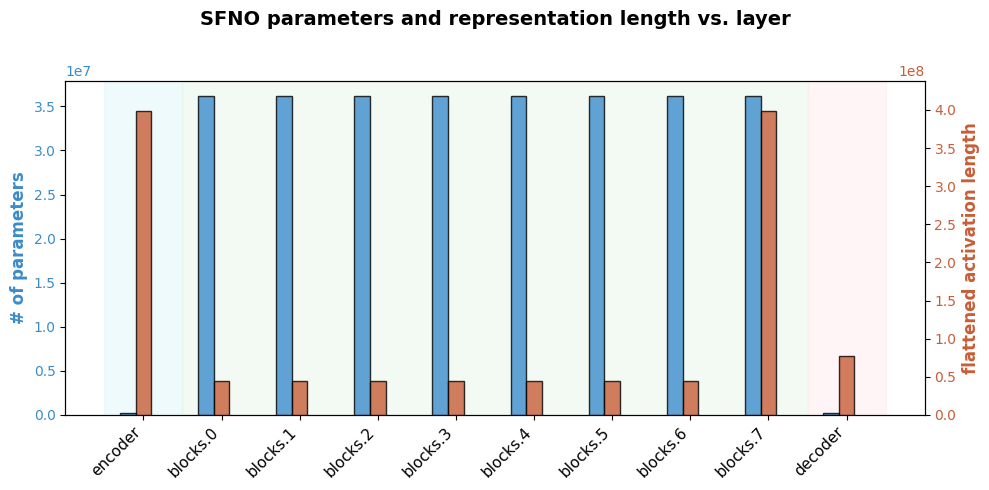

In [3]:
# --- 6. GENERATE THE PLOT ---
from cmocean import cm

print("Generating plot...")
layers = list(layer_stats.keys())
params = [layer_stats[l]['params'] for l in layers]
act_sizes = [layer_stats[l]['act_size'] for l in layers]

fig, ax1 = plt.subplots(figsize=(10, 5))
x = np.arange(len(layers))

width=0.2

color1 = cm.phase(0.6)  # Teal-ish for parameters
bars = ax1.bar(x-width, params, width=width, color=color1, alpha=0.8, edgecolor='black', zorder=3)
ax1.set_ylabel('# of parameters', color=color1, fontsize=12, fontweight='bold')
# ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(x)
ax1.set_xticklabels(layers, rotation=45, ha='right', fontsize=11)

ax2 = ax1.twinx()
color2 = cm.phase(0.1)  # Orange-ish for activation sizes
line = ax2.bar(x, act_sizes, width=width, color=color2, alpha=0.8, edgecolor='black', zorder=3)
ax2.set_ylabel('flattened activation length', color=color2, fontsize=12, fontweight='bold')
# ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(act_sizes) * 1.1)

ax1.axvspan(-0.5, 0.5, color='#e0f7fa', alpha=0.5, zorder=1)
ax1.axvspan(0.5, 8.5, color='#e8f5e9', alpha=0.5, zorder=1)
ax1.axvspan(8.5, 9.5, color='#ffebee', alpha=0.5, zorder=1)

plt.title('SFNO parameters and representation length vs. layer', fontsize=14, fontweight='bold', pad=40)
plt.tight_layout()

plot_path = os.path.join(os.getcwd(),'viz', 'figures', 'sfno_architecture_stats.png')
plt.savefig(plot_path, dpi=300)
print(f"Plot saved successfully to: {plot_path}")

In [1]:
#  IDENTIFYING CORRUPT DATA   #
import os
import xarray as xr
from glob import glob

init_dir = "/projectnb/eb-general/wade/sfno/inference_runs/intrinsic_dim/init_files/"
# Find all the initialization files
files = sorted(glob(os.path.join(init_dir, "Initialize_*.nc")))

print(f"Found {len(files)} files. Checking integrity...\n")

bad_files = []

for i, fp in enumerate(files):
    filename = os.path.basename(fp)
    
    # 1. Check if the file is suspiciously small (e.g., 0 bytes)
    size_bytes = os.path.getsize(fp)
    if size_bytes < 1024: # Less than 1KB is almost certainly corrupted
        print(f"[{i+1}/{len(files)}] ❌ SIZE ERROR: {filename} is only {size_bytes} bytes!")
        bad_files.append(fp)
        continue
        
    # 2. Try to read the header with xarray
    try:
        # Opening without loading data into memory
        with xr.open_dataset(fp) as ds: 
            pass 
    except Exception as e:
        print(f"[{i+1}/{len(files)}] ❌ CORRUPT: {filename} cannot be opened. Error: {type(e).__name__}")
        bad_files.append(fp)

print(f"\nScan complete. Found {len(bad_files)} bad files.")

Found 1001 files. Checking integrity...

[47/1001] ❌ SIZE ERROR: Initialize_2022_01_12T06_nsteps1.nc is only 0 bytes!

Scan complete. Found 1 bad files.


In [4]:
import os
import json
import torch
import pandas as pd
from earth2studio.io import ZarrBackend
from earth2studio.models.auto import Package
import earth2studio.data as data
from SFNO_update import SFNO
from utils import get_sequential_initializations
from datetime import datetime

# --- 1. SETUP & LOAD MODEL ---
experiment_number = 1
config_path = f'./configs/exp{experiment_number}.json'
with open(config_path, 'r') as f: config = json.load(f)

print("Loading model...")
src_dir = "/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/Checkpoints_SFNO/sfno_linear_74chq_sc3_layers8_edim384_dt6h_wstgl2/v0.1.0-seed999/"
checkpoint_name = 'ckpt_mp0_epoch1.tar'
model_package = Package(src_dir, cache=False)
model_wrapper = SFNO.load_model(model_package, checkpoint_name=checkpoint_name, EMA=False)

# Access the core model
sfno_core = model_wrapper.model.model.model 

# --- 2. PREPARE STORAGE ---
# We will store results in a list of dictionaries for easy DataFrame conversion
layer_registry = {} 

# --- 3. DEFINE HOOKS ---
def get_inspector_hook(name):
    def hook(module, input, output):
        # Handle tuple outputs (common in RNNs or Transformers)
        if isinstance(output, tuple):
            # Try to guess which one is the activation (usually the first one with gradients)
            # For inspection, we'll just grab the first one
            out_tensor = output[0]
        else:
            out_tensor = output
        
        # Check if it's actually a tensor (some layers might output None or metadata)
        if isinstance(out_tensor, torch.Tensor):
            shape = list(out_tensor.shape)
            # Flattened size per sample (divide by batch size if batch dim exists)
            # Assuming dim 0 is batch
            flat_size = out_tensor.numel() // shape[0] if shape[0] > 0 else 0
        else:
            shape = "Non-Tensor"
            flat_size = 0

        layer_registry[name]['output_shape'] = shape
        layer_registry[name]['flat_size'] = flat_size
    return hook

# --- 4. REGISTER HOOKS ON EVERYTHING ---
print("Attaching hooks to ALL modules...")
hooks = []

for name, module in sfno_core.named_modules():
    if name == "": continue # Skip the root container itself
    
    # Initialize data container
    layer_registry[name] = {
        'class': type(module).__name__,
        'params': sum(p.numel() for p in module.parameters(recurse=False)), # Only count params attached directly to this node
        'output_shape': None,
        'flat_size': 0
    }
    
    # Register hook
    hooks.append(module.register_forward_hook(get_inspector_hook(name)))

# --- 5. RUN INFERENCE ---
print("Running single sample...")
init_fps, start_timesteps = get_sequential_initializations([2021], 1)
init_fp = init_fps[0]
initial_data = data.DataArrayFile(init_fp)
io = ZarrBackend()
start_datetime = datetime.fromisoformat(start_timesteps[0])

with torch.no_grad():
    deterministic([start_datetime], 1, model_wrapper, initial_data, io, variables_list=None)

# Cleanup hooks
for h in hooks: h.remove()

# --- 6. PRINT HIERARCHICAL REPORT ---
print("\n" + "="*100)
print(f"{'LAYER HIERARCHY':<50} | {'CLS':<15} | {'PARAMS':<10} | {'OUT SHAPE'}")
print("-" * 100)

for name, data in layer_registry.items():
    # Indent based on depth (dots in the name)
    depth = name.count('.')
    indent = "  " * depth
    pretty_name = indent + name.split('.')[-1]
    
    # Formatting
    p_count = f"{data['params']:,}" if data['params'] > 0 else ""
    shape_str = str(data['output_shape'])
    cls_name = data['class']
    
    # Filter out empty containers to reduce noise? (Optional: Comment out next line to see everything)
    # if data['params'] == 0 and data['flat_size'] == 0: continue

    print(f"{pretty_name:<50} | {cls_name[:15]:<15} | {p_count:<10} | {shape_str}")

print("="*100 + "\n")

# # --- 7. EXPORT TO CSV (Optional but recommended for analysis) ---
# df = pd.DataFrame.from_dict(layer_registry, orient='index')
# df.index.name = 'layer_name'
# csv_path = "sfno_full_architecture.csv"
# df.to_csv(csv_path)
# print(f"Full architecture details saved to {csv_path}")

Loading model...
Attaching hooks to ALL modules...
Running single sample...
Initialization file /projectnb/eb-general/wade/sfno/inference_runs/intrinsic_dim/init_files/Initialize_2021_01_01T00_nsteps1.nc already exists, skipping creation.


Running inference: 100%|██████████| 2/2 [02:03<00:00, 61.75s/it]


LAYER HIERARCHY                                    | CLS             | PARAMS     | OUT SHAPE
----------------------------------------------------------------------------------------------------
trans_down                                         | RealSHT         |            | [1, 384, 240, 241]
itrans_up                                          | InverseRealSHT  |            | [1, 384, 721, 1440]
trans                                              | RealSHT         |            | [1, 384, 240, 241]
itrans                                             | InverseRealSHT  |            | [1, 384, 240, 480]
encoder                                            | EncoderDecoder  |            | [1, 384, 721, 1440]
  fwd                                              | Sequential      |            | [1, 384, 721, 1440]
    0                                              | Conv2d          | 42,624     | [1, 384, 721, 1440]
    1                                              | GELU            |         